# Going Deeper(CV) - 10. 도로 영역을 찾자! - 세그멘테이션 모델 만들기

sementic segmentation을 이용하여 도로를 찾아 보자.

---

### 루브릭 평가 기준

1. U-Net을 통한 세그멘테이션 진행 - KITTI 데이터셋 구성, U-Net 모델 훈련, 결과물 시각화의 한 사이클이 정상 수행되어 세그멘테이션 결과 이미지를 제출하였나

2. U-Net++ 모델 구현 - U-Net++ 모델을 스스로 구현하여 학습 진행 후 세그멘테이션 결과까지 진행되었나

3. U-Net과 U-Net++ 모델 성능의 정량적/정성적 비교 - U-Net++ 의 세그멘테이션 결과 사진과 IoU 계산치를 U-Net과 비교하여 확인하였나

---

### 목차

0) 필요 모듈 import


1) 데이터 로드 및 augmentation


2) U-Net 구조 및 학습 결과 확인


3) U-Net++ 구조 및 학습 결과 확인
  
  
4) 결과 비교


5) 회고

## 0. 필요 모듈 import

In [1]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. 데이터 로드 및 augmentation

In [3]:
def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

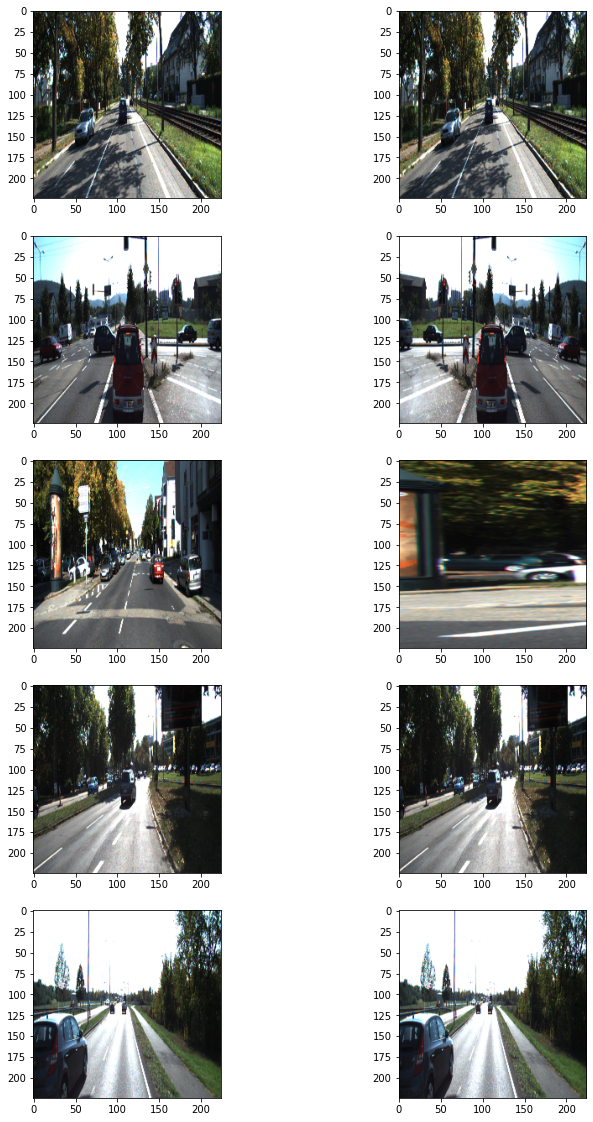

In [4]:
dir_path = '/content/drive/MyDrive/ColabNotebooks/GoingDeeper/10/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [5]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [6]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## 2. U-Net 구조 및 학습 결과 확인

In [7]:
def build_Unet(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
	
    #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
    
    #Expanding Path
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)

    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)

    up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)

    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)

    up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)

    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)

    up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)

    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [8]:
unet_model = build_Unet()
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [9]:
unet_model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')

이미 100epoch 학습 된 모델을 불러와 사용

In [10]:
model_path = dir_path + '/seg_model_unet.h5' 

unet_model = tf.keras.models.load_model(model_path)

결과 확인

In [11]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [12]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    display(output)   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

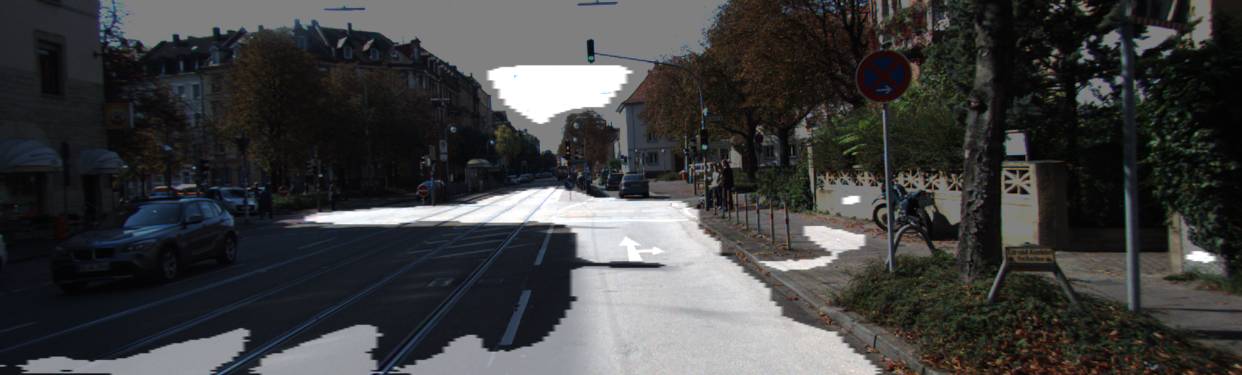

IoU : 0.419641


0.41964089410040306

In [13]:
i = 1  
output, prediction, target = get_output(
     unet_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

## 3. U-Net++ 구조 및 결과 확인

In [14]:
def build_Unet_plus(input_shape=(224, 224, 3), filters= [0, 64, 128, 256, 512], kernel=3):
    inputs = Input(input_shape)

    x1_0 = MaxPooling2D(pool_size=(2,2), name='x1_0_pool')(inputs)
    x1_0 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_0_conv1')(inputs)
    x1_0 = BatchNormalization()(x1_0)
    x1_0 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_0_conv2')(x1_0)
    x1_0 = BatchNormalization()(x1_0)
    
    x2_0 = MaxPooling2D(pool_size=(2,2), name='x2_0_pool')(x1_0)
    x2_0 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x2_0_conv1')(x2_0)
    x2_0 = BatchNormalization()(x2_0)
    x2_0 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x2_0_conv2')(x2_0)
    x2_0 = BatchNormalization()(x2_0)
    
    x3_0 = MaxPooling2D(pool_size=(2,2), name='x3_0_pool')(x2_0)
    x3_0 = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x3_0_conv1')(x3_0)
    x3_0 = BatchNormalization()(x3_0)
    x3_0 = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x3_0_conv2')(x3_0)
    x3_0 = BatchNormalization()(x3_0)
    
    x4_0 = MaxPooling2D(pool_size=(2,2), name='x4_0_pool')(x3_0)
    x4_0 = Conv2D(filters[4], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x4_0_conv1')(x4_0)
    x4_0 = BatchNormalization()(x4_0)
    x4_0 = Conv2D(filters[4], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x4_0_conv2')(x4_0)
    x4_0 = BatchNormalization()(x4_0)
    
    u4_0 = Conv2DTranspose(filters[3], (2, 2), strides=(2, 2), padding='valid', name='u4_0_convTran')(x4_0)
    r3_0 = tf.image.resize(x3_0, (u4_0.shape[1], u4_0.shape[2]), name='x3_0_resize')
    x3_1 = concatenate([r3_0, u4_0], axis = 3, name='x3_1_merge')
    x3_1 = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x3_1_conv1')(x3_1)
    x3_1 = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x3_1_conv2')(x3_1)
    
    # 2-2
    u3_0 = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding='valid', name='u3_0_convTran')(x3_0)
    r2_0 = tf.image.resize(x2_0, (u3_0.shape[1], u3_0.shape[2]), name='a_r2_0_resize')
    x2_1 = concatenate([r2_0,u3_0], axis = 3, name='x2_1_merge')
    x2_1 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x2_1_conv1')(x2_1)
    x2_1 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x2_1_conv2')(x2_1)
    
    # origin
    u3_1 = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding='valid', name='u3_1_convTran')(x3_1)
    r2_0 = tf.image.resize(x2_0, (u3_1.shape[1], u3_1.shape[2]), name='b_r2_0_resize')
    r2_1 = tf.image.resize(x2_1, (u3_1.shape[1], u3_1.shape[2]), name='b_r2_1_resize')
    x2_2 = concatenate([r2_0,r2_1, u3_1], axis = 3, name='x2_2_merge')
    x2_2 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x2_2_conv1')(x2_2)
    x2_2 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x2_2_conv2')(x2_2)
    
    # 1-3
    u2_0 = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding='valid', name='u2_0_convTran')(x2_0)
    r1_0 = tf.image.resize(x1_0, (u2_0.shape[1], u2_0.shape[2]), name='a_r1_0_resize')
    x1_1 = concatenate([r1_0,u2_0], axis = 3, name='x1_1_merge')
    x1_1 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_1_conv1')(x1_1)
    x1_1 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_1_conv2')(x1_1)
    
    # 1-3
    u2_1 = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding='valid', name='u2_1_convTran')(x2_1)
    r1_0 = tf.image.resize(x1_0, (u2_1.shape[1], u2_1.shape[2]), name='b_r1_0_resize')
    r1_1 = tf.image.resize(x1_1, (u2_1.shape[1], u2_1.shape[2]), name='b_r1_1_resize')
    x1_2 = concatenate([r1_0, r1_1, u2_1], axis = 3, name='x1_2_merge')
    x1_2 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_2_conv1')(x1_2)
    x1_2 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_2_conv2')(x1_2)
    
    # origin
    u2_2 = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding='valid', name='u2_2_convTran')(x2_2)
    r1_0 = tf.image.resize(x1_0, (u2_2.shape[1], u2_2.shape[2]), name='c_r1_0_resize')
    r1_1 = tf.image.resize(x1_1, (u2_2.shape[1], u2_2.shape[2]), name='c_r1_1_resize')
    r1_2 = tf.image.resize(x1_2, (u2_2.shape[1], u2_2.shape[2]), name='c_r1_2_resize')
    x1_3 = concatenate([r1_0, r1_1, r1_2, u2_2], axis = 3, name='x1_3_merge')
    x1_3 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_3_conv1')(x1_3)
    x1_3 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_3_conv2')(x1_3)
    x1_3 = Conv2D(2, kernel, activation='relu', padding='same',kernel_initializer='he_normal', name='x1_3_conv3')(x1_3)
    x1_3 = Conv2D(1, 1, activation='sigmoid')(x1_3)

    output = tf.image.resize(x1_3, (inputs.shape[1], inputs.shape[2]), name='output')
    model = Model(inputs = inputs, outputs = output)

    return model

In [15]:
unet_plus2_model = build_Unet_plus()
unet_plus2_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 x1_0_conv1 (Conv2D)            (None, 222, 222, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 222, 222, 64  256        ['x1_0_conv1[0][0]']             
 alization)                     )                                                           

In [16]:
unet_plus2_model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')

unet_plus2_model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_path = dir_path + '/seg_model_unet_plus2.h5'
unet_plus2_model.save(model_path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/100
11/11 [==============================] - 32s 1s/step - loss: 0.6014 - val_loss: 0.6619
Epoch 2/100
11/11 [==============================] - 10s 898ms/step - loss: 0.1644 - val_loss: 0.1390
Epoch 3/100
11/11 [==============================] - 10s 892ms/step - loss: 0.0294 - val_loss: 0.0404
Epoch 4/100
11/11 [==============================] - 10s 874ms/step - loss: 0.0307 - val_loss: 0.0364
Epoch 5/100
11/11 [==============================] - 10s 867ms/step - loss: 0.0246 - val_loss: 0.0370
Epoch 6/100
11/11 [==============================] - 9s 864ms/step - loss: 0.0286 - val_loss: 0.0377
Epoch 7/100
11/11 [==============================] - 9s 860ms/step - loss: 0.0284 - val_loss: 0.0402
Epoch 8/100
11/11 [==============================] - 9s 859ms/step - loss: 0.0240 - val_loss: 0.0375
Epoch 9/100
11/11 [==============================] - 9s 861ms/step - loss: 0.0252 - val_loss: 0.0383
Epoch 10/100
11/11 [==============================] - 9s 864ms/step - loss: 0.0229 - val_

In [17]:
model_path = dir_path + '/seg_model_unet_plus2.h5' 

unet_plus2_model = tf.keras.models.load_model(model_path)

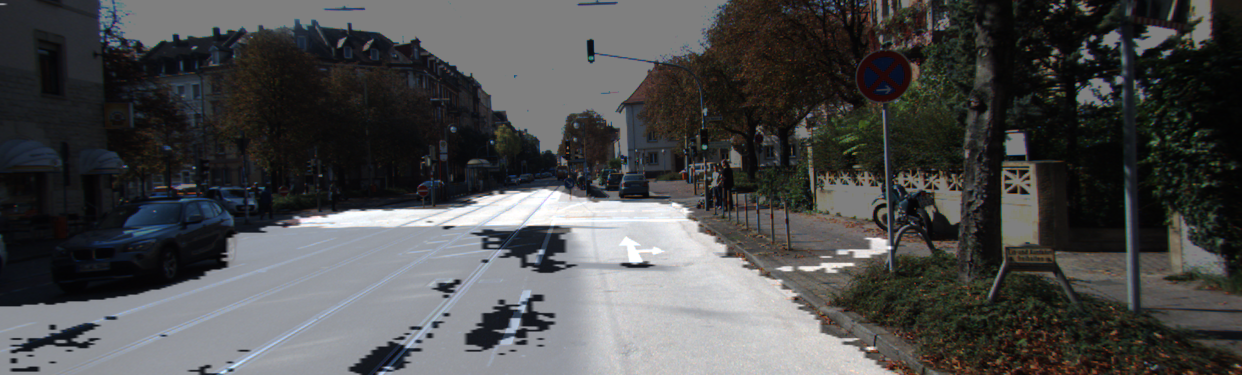

IoU : 0.857265


0.8572645600991325

In [18]:
i = 1 
output, prediction, target = get_output(
     unet_plus2_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

## 4. 결과 확인

U-Net과 U-Net++를 이용한 결과를 비교해 보자.

In [19]:
def get_output_without_display(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    # display(output)   # 시각화 생략
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [22]:
unet_iou = []
unet_plus_iou = []

for i in range(1, 201, 4):
    # UNet 결과
    output, prediction, target = get_output_without_display(
     unet_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png')
    
    unet_iou.append(calculate_iou_score(target, prediction))

    #UNet++ 결과
    output, prediction, target = get_output_without_display(
     unet_plus2_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png')
    
    unet_plus_iou.append(calculate_iou_score(target, prediction))

IoU : 0.419641
IoU : 0.857265
IoU : 0.647032
IoU : 0.743734
IoU : 0.417902
IoU : 0.512755
IoU : 0.427770
IoU : 0.760958
IoU : 0.620941
IoU : 0.824564
IoU : 0.206589
IoU : 0.029029
IoU : 0.589673
IoU : 0.665534
IoU : 0.285741
IoU : 0.628154
IoU : 0.303667
IoU : 0.620456
IoU : 0.443283
IoU : 0.612799
IoU : 0.477312
IoU : 0.702215
IoU : 0.516127
IoU : 0.541355
IoU : 0.541490
IoU : 0.483124
IoU : 0.561623
IoU : 0.603422
IoU : 0.069846
IoU : 0.135822
IoU : 0.417208
IoU : 0.516692
IoU : 0.340716
IoU : 0.363114
IoU : 0.375018
IoU : 0.140650
IoU : 0.771391
IoU : 0.941992
IoU : 0.437187
IoU : 0.749612
IoU : 0.495169
IoU : 0.814918
IoU : 0.215903
IoU : 0.594707
IoU : 0.830578
IoU : 0.898757
IoU : 0.713547
IoU : 0.590927
IoU : 0.820909
IoU : 0.895340
IoU : 0.369194
IoU : 0.640675
IoU : 0.465497
IoU : 0.520302
IoU : 0.446464
IoU : 0.635856
IoU : 0.554036
IoU : 0.703299
IoU : 0.495189
IoU : 0.693148
IoU : 0.481850
IoU : 0.536883
IoU : 0.429777
IoU : 0.581564
IoU : 0.620173
IoU : 0.847794
IoU : 0.63

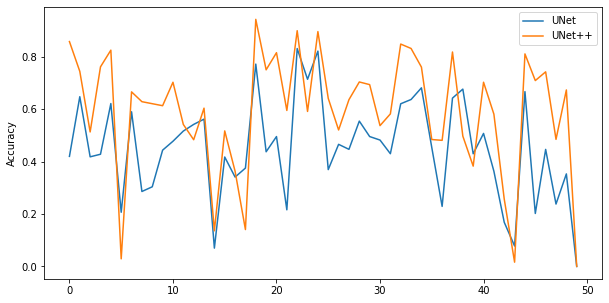

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(unet_iou, label='UNet')
plt.plot(unet_plus_iou, label='UNet++')
plt.ylabel('Accuracy')
plt.legend()

몇몇 이미지에 대해서는 U-Net의 결과가 더 좋은 경우가 있지만 전체적으로 U-Net++ 모델에 대한 결과가 더 좋은 것을 확인할 수 있다.

## 5. 회고

#### - 이미지가 안나온다!!!!
코랩에서는 PIL을 이용한 이미지 불러오기 .show( )가 안된다. 그동안 plt만 이용했어서 전혀 생각지도 못한 부분이다.. 
[출처](https://lapina.tistory.com/81)

#### - 모델을 만드는건 어려워~~
아직 논문만 보고 스스로 모델을 구현하는 것은 어렵다.. 이번에도 역시나 [선배님](https://github.com/PEBpung/Aiffel/blob/19501a33373815a085532bff0dd4404f93678771/Project/Going%20Deeper/G8_Segmentation.ipynb)의 코드를 보고 프로젝트를 마무리 할 수 있었다.